请将运行结果和图等实验步骤结果保留在jupyter之中

## 一、手动实现前馈神经网络解决上述回归、二分类、多分类任务

In [2]:
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torch.nn.functional import cross_entropy, binary_cross_entropy
from torch.nn import CrossEntropyLoss
from torchvision import transforms
from sklearn import  metrics


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("正在使用device: ", device)

正在使用device:  cuda


In [4]:
train_data_mnist = torchvision.datasets.MNIST(root="../data/MNIST", train=True, transform=transforms.ToTensor(), download=True)
test_data_mnist = torchvision.datasets.MNIST(root="../data/MNIST", train=False, transform=transforms.ToTensor())

In [5]:
# 数据集定义 生成用于回归任务的数据集
# 构建回归数据集合 - traindataloader1, testdataloader1
data_num, train_num, test_num = 10000, 7000, 3000 # 分别为样本总数量，训练集样本数量和测试集样本数量
true_w, true_b = 0.0056 * torch.ones(500,1), 0.028 
features = torch.randn(10000, 500)
labels = torch.matmul(features,true_w) + true_b # 按高斯分布
labels += torch.tensor(np.random.normal(0,0.01,size=labels.size()),dtype=torch.float32)

In [6]:
# 划分训练集和测试集
train_features, test_features = features[:train_num,:], features[train_num:,:]
train_labels, test_labels = labels[:train_num], labels[train_num:]
batch_size = 128
traindataset1 = torch.utils.data.TensorDataset(train_features,train_labels)
testdataset1 = torch.utils.data.TensorDataset(test_features, test_labels)
traindataloader1 = torch.utils.data.DataLoader(dataset=traindataset1,batch_size=batch_size,shuffle=True)
testdataloader1 = torch.utils.data.DataLoader(dataset=testdataset1,batch_size=batch_size,shuffle=True)


In [ ]:
## 生成用于二分类任务的数据集
data_num, train_num, test_num = 10000, 7000, 3000  # 分别为样本总数量，训练集样本数量和测试集样本数量
# 第一个数据集 符合均值为 0.5 标准差为1 得分布
features1 = torch.normal(mean=0.2, std=2, size=(data_num, 200), dtype=torch.float32)
labels1 = torch.ones(data_num)
# 第二个数据集 符合均值为 -0.5 标准差为1的分布
features2 = torch.normal(mean=-0.2, std=2, size=(data_num, 200), dtype=torch.float32)
labels2 = torch.zeros(data_num)

# 构建训练数据集
train_features2 = torch.cat((features1[:train_num], features2[:train_num]), dim=0)  # size torch.Size([14000, 200])
train_labels2 = torch.cat((labels1[:train_num], labels2[:train_num]), dim=-1)  # size  torch.Size([6000, 200])
# 构建测试数据集
test_features2 = torch.cat((features1[train_num:], features2[train_num:]), dim=0)  # torch.Size([14000])
test_labels2 = torch.cat((labels1[train_num:], labels2[train_num:]), dim=-1)  # torch.Size([6000])
batch_size = 128
# Build the training and testing dataset
traindataset2 = torch.utils.data.TensorDataset(train_features2, train_labels2)
testdataset2 = torch.utils.data.TensorDataset(test_features2, test_labels2)
traindataloader2 = torch.utils.data.DataLoader(dataset=traindataset2,batch_size=batch_size,shuffle=True)
testdataloader2 = torch.utils.data.DataLoader(dataset=testdataset2,batch_size=batch_size,shuffle=True)

In [92]:
# 定义多分类数据集 - train_dataloader - test_dataloader
batch_size = 128
# Build the training and testing dataset
traindataset3 = torchvision.datasets.MNIST(root='../data',
                                                  train=True,
                                                  download=True,
                                                  transform=transforms.ToTensor())
testdataset3 = torchvision.datasets.MNIST(root='../data',
                                                 train=False,
                                                 download=True,
                                                 transform=transforms.ToTensor())
traindataloader3 = torch.utils.data.DataLoader(traindataset3, batch_size=batch_size, shuffle=True)
testdataloader3 = torch.utils.data.DataLoader(testdataset3, batch_size=batch_size, shuffle=False)
# 绘制图像的代码
def picture(name, trainl, testl, type='Loss'):
    plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
    plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题
    plt.title(name) # 命名
    plt.plot(trainl, c='g', label='Train '+ type)
    plt.plot(testl, c='r', label='Test '+type)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
print(f'回归数据集   样本总数量{len(traindataset1) + len(testdataset1)},训练样本数量{len(traindataset1)},测试样本数量{len(testdataset1)}')
print(f'二分类数据集 样本总数量{len(traindataset2) + len(testdataset2)},训练样本数量{len(traindataset2)},测试样本数量{len(testdataset2)}')
print(f'多分类数据集 样本总数量{len(traindataset3) + len(testdataset3)},训练样本数量{len(traindataset3)},测试样本数量{len(testdataset3)}')

100.0%
100.0%
100.0%
100.0%

回归数据集   样本总数量10000,训练样本数量9300,测试样本数量700
二分类数据集 样本总数量20000,训练样本数量18600,测试样本数量1400
多分类数据集 样本总数量70000,训练样本数量60000,测试样本数量10000


In [ ]:
# 定义自己的前馈神经网络
class MyNet1():
    def __init__(self):
        # 设置隐藏层和输出层的节点数
        num_inputs, num_hiddens, num_outputs = 500, 256, 1
        w_1 = torch.tensor(np.random.normal(0,0.01,(num_hiddens,num_inputs)),dtype=torch.float32,requires_grad=True)
        b_1 = torch.zeros(num_hiddens, dtype=torch.float32,requires_grad=True)
        w_2 = torch.tensor(np.random.normal(0, 0.01,(num_outputs, num_hiddens)),dtype=torch.float32,requires_grad=True)
        b_2 = torch.zeros(num_outputs,dtype=torch.float32, requires_grad=True)
        self.params = [w_1, b_1, w_2, b_2]
        # 定义模型结构
        self.input_layer = lambda x: x.view(x.shape[0],-1)
        self.hidden_layer = lambda x: self.my_relu(torch.matmul(x,w_1.t())+b_1)
        self.output_layer = lambda x: torch.matmul(x,w_2.t()) + b_2

    def my_relu(self, x):
        return torch.max(input=x,other=torch.tensor(0.0))

    def forward(self,x):
        x = self.input_layer(x)
        x = self.my_relu(self.hidden_layer(x))
        x = self.output_layer(x)
        return x
    
def mySGD(params, lr, batchsize):
    for param in params:
        param.data -= lr*param.grad / batchsize

def mse(pred, true):
    ans = torch.sum((true-pred)**2) / len(pred)
    # print(ans)
    return ans

In [10]:
# 开始训练
model1 = MyNet1()  # logistics模型
criterion = CrossEntropyLoss()   # 损失函数
lr = 0.05   # 学习率
batchsize = 128 
epochs = 100 #训练轮数
train_all_loss1 = [] # 记录训练集上得loss变化
test_all_loss1 = [] #记录测试集上的loss变化
begintime1 = time.time()
for epoch in range(epochs):
    train_l = 0
    for data, labels in traindataloader1:
        pred = model1.forward(data)
        train_each_loss = mse(pred.view(-1,1), labels.view(-1,1)) #计算每次的损失值
        train_each_loss.backward() # 反向传播
        mySGD(model1.params, lr, batchsize) # 使用小批量随机梯度下降迭代模型参数
        # 梯度清零
        train_l += train_each_loss.item()
        for param in model1.params:
            param.grad.data.zero_()
        # print(train_each_loss)
    train_all_loss1.append(train_l) # 添加损失值到列表中
    with torch.no_grad():
        test_loss = 0
        for data, labels in traindataloader1:
            pred = model1.forward(data)
            test_each_loss = mse(pred, labels)
            test_loss += test_each_loss.item()
        test_all_loss1.append(test_loss)
    if epoch==0 or (epoch+1) % 4 == 0:
        print('epoch: %d | train loss:%.5f | test loss:%.5f'%(epoch+1,train_all_loss1[-1],test_all_loss1[-1]))
endtime1 = time.time()
print("手动实现前馈网络-回归实验 %d轮 总用时: %.3fs"%(epochs,endtime1-begintime1))


epoch: 1 | train loss:0.89767 | test loss:0.89606
epoch: 4 | train loss:0.89254 | test loss:0.89161
epoch: 8 | train loss:0.88727 | test loss:0.88627
epoch: 12 | train loss:0.88397 | test loss:0.88345
epoch: 16 | train loss:0.87968 | test loss:0.87893
epoch: 20 | train loss:0.87579 | test loss:0.87517
epoch: 24 | train loss:0.87105 | test loss:0.87089
epoch: 28 | train loss:0.86859 | test loss:0.86747
epoch: 32 | train loss:0.86371 | test loss:0.86475
epoch: 36 | train loss:0.86010 | test loss:0.85993
epoch: 40 | train loss:0.85676 | test loss:0.85648
epoch: 44 | train loss:0.85367 | test loss:0.85378
epoch: 48 | train loss:0.85178 | test loss:0.84843
epoch: 52 | train loss:0.84679 | test loss:0.84590
epoch: 56 | train loss:0.84194 | test loss:0.84208
epoch: 60 | train loss:0.83986 | test loss:0.83710
epoch: 64 | train loss:0.83541 | test loss:0.83597
epoch: 68 | train loss:0.83130 | test loss:0.83023
epoch: 72 | train loss:0.82816 | test loss:0.82777
epoch: 76 | train loss:0.82535 | t

In [11]:
# 定义自己的前馈神经网络
class MyNet2():
    def __init__(self):
        # 设置隐藏层和输出层的节点数
        num_inputs, num_hiddens, num_outputs = 200, 256, 1
        w_1 = torch.tensor(np.random.normal(0, 0.01, (num_hiddens, num_inputs)), dtype=torch.float32,
                           requires_grad=True)
        b_1 = torch.zeros(num_hiddens, dtype=torch.float32, requires_grad=True)
        w_2 = torch.tensor(np.random.normal(0, 0.01, (num_outputs, num_hiddens)), dtype=torch.float32,
                           requires_grad=True)
        b_2 = torch.zeros(num_outputs, dtype=torch.float32, requires_grad=True)
        self.params = [w_1, b_1, w_2, b_2]

        # 定义模型结构
        self.input_layer = lambda x: x.view(x.shape[0], -1)
        self.hidden_layer = lambda x: self.my_relu(torch.matmul(x, w_1.t()) + b_1)
        self.output_layer = lambda x: torch.matmul(x, w_2.t()) + b_2
        self.fn_logistic = self.logistic

    def my_relu(self, x):
        return torch.max(input=x, other=torch.tensor(0.0))

    def logistic(self, x):  # 定义logistic函数
        x = 1.0 / (1.0 + torch.exp(-x))
        return x

    # 定义前向传播
    def forward(self, x):
        x = self.input_layer(x)
        x = self.my_relu(self.hidden_layer(x))
        x = self.fn_logistic(self.output_layer(x))
        return x


def mySGD(params, lr):
    for param in params:
        param.data -= lr * param.grad

# 训练
model2 = MyNet2()
lr = 0.01  # 学习率
epochs = 100  # 训练轮数
train_all_loss2 = []  # 记录训练集上得loss变化
test_all_loss2 = []  # 记录测试集上的loss变化
train_Acc12, test_Acc12 = [], []
begintime2 = time.time()
for epoch in range(epochs):
    train_l, train_epoch_count = 0, 0
    for data, labels in traindataloader2:
        pred = model2.forward(data)
        train_each_loss = binary_cross_entropy(pred.view(-1), labels.view(-1))  # 计算每次的损失值
        train_l += train_each_loss.item()
        train_each_loss.backward()  # 反向传播
        mySGD(model2.params, lr)  # 使用随机梯度下降迭代模型参数
        # 梯度清零
        for param in model2.params:
            param.grad.data.zero_()
        # print(train_each_loss)
        train_epoch_count += (torch.tensor(np.where(pred > 0.5, 1, 0)).view(-1) == labels).sum()
    train_Acc12.append((train_epoch_count/len(traindataset2)).item())
    train_all_loss2.append(train_l)  # 添加损失值到列表中
    with torch.no_grad():
        test_l, test_epoch_count = 0, 0
        for data, labels in testdataloader2:
            pred = model2.forward(data)
            test_each_loss = binary_cross_entropy(pred.view(-1), labels.view(-1))
            test_l += test_each_loss.item()
            test_epoch_count += (torch.tensor(np.where(pred > 0.5, 1, 0)).view(-1) == labels.view(-1)).sum()
        test_Acc12.append((test_epoch_count/len(testdataset2)).item())
        test_all_loss2.append(test_l)
    if epoch == 0 or (epoch + 1) % 4 == 0:
        print('epoch: %d | train loss:%.5f | test loss:%.5f | train acc:%.5f | test acc:%.5f'  % (epoch + 1, train_all_loss2[-1], test_all_loss2[-1], train_Acc12[-1], test_Acc12[-1]))
endtime2 = time.time()
print("手动实现前馈网络-二分类实验 %d轮 总用时: %.3f" % (epochs, endtime2 - begintime2))


epoch: 1 | train loss:74.52381 | test loss:30.83711 | train acc:0.75229 | test acc:0.87350
epoch: 4 | train loss:37.40426 | test loss:13.82826 | train acc:0.92071 | test acc:0.91650
epoch: 8 | train loss:21.97992 | test loss:9.60361 | train acc:0.92757 | test acc:0.91933
epoch: 12 | train loss:19.95553 | test loss:9.24377 | train acc:0.93100 | test acc:0.91783
epoch: 16 | train loss:18.91990 | test loss:9.24875 | train acc:0.93336 | test acc:0.91850
epoch: 20 | train loss:18.16891 | test loss:9.30830 | train acc:0.93564 | test acc:0.91800
epoch: 24 | train loss:17.60432 | test loss:9.36086 | train acc:0.93843 | test acc:0.91917
epoch: 28 | train loss:16.96085 | test loss:9.40916 | train acc:0.94157 | test acc:0.91800
epoch: 32 | train loss:16.23851 | test loss:9.45641 | train acc:0.94486 | test acc:0.91817
epoch: 36 | train loss:15.58163 | test loss:9.49750 | train acc:0.94807 | test acc:0.91867
epoch: 40 | train loss:14.96598 | test loss:9.54069 | train acc:0.95214 | test acc:0.91867


In [12]:
# 定义自己的前馈神经网络
class MyNet3():
    def __init__(self):
        # 设置隐藏层和输出层的节点数
        num_inputs, num_hiddens, num_outputs = 28 * 28, 256, 10  # 十分类问题
        w_1 = torch.tensor(np.random.normal(0, 0.01, (num_hiddens, num_inputs)), dtype=torch.float32,
                           requires_grad=True)
        b_1 = torch.zeros(num_hiddens, dtype=torch.float32, requires_grad=True)
        w_2 = torch.tensor(np.random.normal(0, 0.01, (num_outputs, num_hiddens)), dtype=torch.float32,
                           requires_grad=True)
        b_2 = torch.zeros(num_outputs, dtype=torch.float32, requires_grad=True)
        self.params = [w_1, b_1, w_2, b_2]

        # 定义模型结构
        self.input_layer = lambda x: x.view(x.shape[0], -1)
        self.hidden_layer = lambda x: self.my_relu(torch.matmul(x, w_1.t()) + b_1)
        self.output_layer = lambda x: torch.matmul(x, w_2.t()) + b_2

    def my_relu(self, x):
        return torch.max(input=x, other=torch.tensor(0.0))

    # 定义前向传播
    def forward(self, x):
        x = self.input_layer(x)
        x = self.hidden_layer(x)
        x = self.output_layer(x)
        return x


def mySGD(params, lr, batchsize):
    for param in params:
        param.data -= lr * param.grad / batchsize

# 训练
model3 = MyNet3()  # logistics模型
criterion = cross_entropy  # 损失函数
lr = 0.15  # 学习率
epochs = 100  # 训练轮数
train_all_loss3 = []  # 记录训练集上得loss变化
test_all_loss3 = []  # 记录测试集上的loss变化
train_ACC13, test_ACC13 = [], [] # 记录正确的个数
begintime3 = time.time()
for epoch in range(epochs):
    train_l,train_acc_num = 0, 0
    for data, labels in traindataloader3:
        pred = model3.forward(data)
        train_each_loss = criterion(pred, labels)  # 计算每次的损失值
        train_l += train_each_loss.item()
        train_each_loss.backward()  # 反向传播
        mySGD(model3.params, lr, 128)  # 使用小批量随机梯度下降迭代模型参数
        # 梯度清零
        train_acc_num += (pred.argmax(dim=1)==labels).sum().item()
        for param in model3.params:
            param.grad.data.zero_()
        # print(train_each_loss)
    train_all_loss3.append(train_l)  # 添加损失值到列表中
    train_ACC13.append(train_acc_num / len(traindataset3)) # 添加准确率到列表中
    with torch.no_grad():
        test_l, test_acc_num = 0, 0
        for data, labels in testdataloader3:
            pred = model3.forward(data)
            test_each_loss = criterion(pred, labels)
            test_l += test_each_loss.item()
            test_acc_num += (pred.argmax(dim=1)==labels).sum().item()
        test_all_loss3.append(test_l)
        test_ACC13.append(test_acc_num / len(testdataset3))   # # 添加准确率到列表中
    if epoch == 0 or (epoch + 1) % 4 == 0:
        print('epoch: %d | train loss:%.5f | test loss:%.5f | train acc: %.2f | test acc: %.2f'
              % (epoch + 1, train_l, test_l, train_ACC13[-1],test_ACC13[-1]))
endtime3 = time.time()
print("手动实现前馈网络-多分类实验 %d轮 总用时: %.3f" % (epochs, endtime3 - begintime3))


epoch: 1 | train loss:1070.46603 | test loss:178.55784 | train acc: 0.31 | test acc: 0.35
epoch: 4 | train loss:922.44105 | test loss:148.24767 | train acc: 0.46 | test acc: 0.45
epoch: 8 | train loss:634.95799 | test loss:103.40591 | train acc: 0.61 | test acc: 0.60
epoch: 12 | train loss:496.63878 | test loss:82.40568 | train acc: 0.65 | test acc: 0.64
epoch: 16 | train loss:427.64625 | test loss:71.88024 | train acc: 0.67 | test acc: 0.66
epoch: 20 | train loss:388.92885 | test loss:65.89450 | train acc: 0.69 | test acc: 0.68
epoch: 24 | train loss:363.69875 | test loss:61.92318 | train acc: 0.71 | test acc: 0.70
epoch: 28 | train loss:344.86466 | test loss:58.92982 | train acc: 0.73 | test acc: 0.72
epoch: 32 | train loss:329.26735 | test loss:56.37900 | train acc: 0.75 | test acc: 0.74
epoch: 36 | train loss:315.94666 | test loss:54.20972 | train acc: 0.77 | test acc: 0.76
epoch: 40 | train loss:304.36890 | test loss:52.33517 | train acc: 0.78 | test acc: 0.77
epoch: 44 | train lo

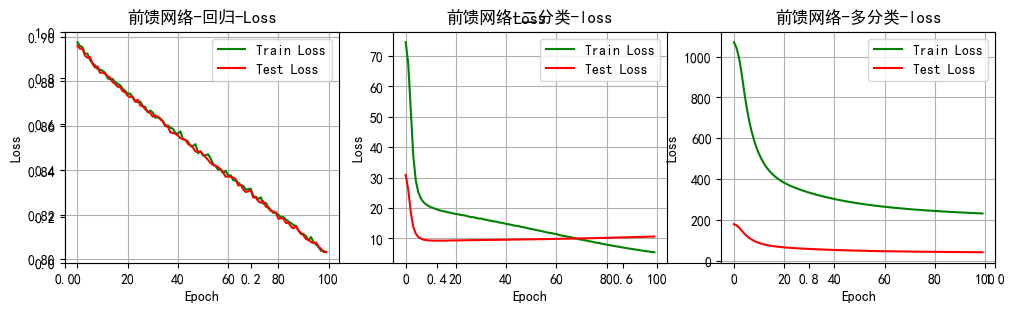

In [13]:
## 进行实验结果分析
plt.figure(figsize=(12,3))
plt.title('Loss')
plt.subplot(131)
picture('前馈网络-回归-Loss',train_all_loss1,test_all_loss1)
plt.subplot(132)
picture('前馈网络-二分类-loss',train_all_loss2,test_all_loss2)
plt.subplot(133)
picture('前馈网络-多分类-loss',train_all_loss3,test_all_loss3)
plt.show()

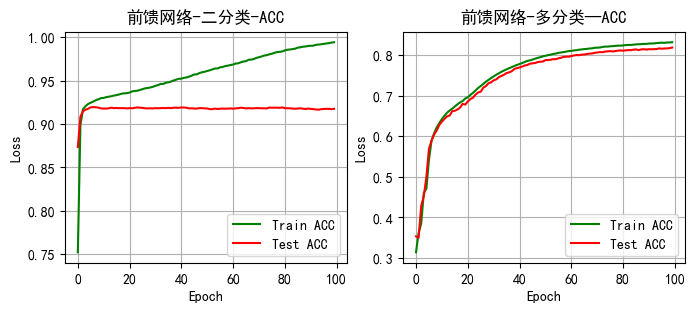

In [14]:
plt.figure(figsize=(8, 3))
plt.subplot(121)
picture('前馈网络-二分类-ACC',train_Acc12,test_Acc12,type='ACC')
plt.subplot(122)
picture('前馈网络-多分类—ACC', train_ACC13,test_ACC13, type='ACC')
plt.show()

## 二、利用torch.nn实现前馈神经网络

In [15]:
from torch.optim import SGD
from torch.nn import MSELoss
# 利用torch.nn实现前馈神经网络-回归任务 代码
# 定义自己的前馈神经网络
class MyNet21(nn.Module):
    def __init__(self):
        super(MyNet21, self).__init__()
        # 设置隐藏层和输出层的节点数
        num_inputs, num_hiddens, num_outputs = 500, 256, 1
        # 定义模型结构
        self.input_layer = nn.Flatten()
        self.hidden_layer = nn.Linear(num_inputs, num_hiddens)
        self.output_layer = nn.Linear(num_hiddens, num_outputs)
        self.relu = nn.ReLU()

    # 定义前向传播
    def forward(self, x):
        x = self.input_layer(x)
        x = self.relu(self.hidden_layer(x))
        x = self.output_layer(x)
        return x

# 训练
model21 = MyNet21()  # logistics模型
model21 = model21.to(device)
print(model21)
criterion = MSELoss()  # 损失函数
criterion = criterion.to(device)
optimizer = SGD(model21.parameters(), lr=0.1)  # 优化函数
epochs = 100  # 训练轮数
train_all_loss21 = []  # 记录训练集上得loss变化
test_all_loss21 = []  # 记录测试集上的loss变化
begintime21 = time.time()
for epoch in range(epochs):
    train_l = 0
    for data, labels in traindataloader1:
        data, labels = data.to(device=device), labels.to(device)
        pred = model21(data)
        train_each_loss = criterion(pred.view(-1, 1), labels.view(-1, 1))  # 计算每次的损失值
        optimizer.zero_grad()  # 梯度清零
        train_each_loss.backward()  # 反向传播
        optimizer.step()  # 梯度更新
        train_l += train_each_loss.item()
    train_all_loss21.append(train_l)  # 添加损失值到列表中
    with torch.no_grad():
        test_loss = 0
        for data, labels in testdataloader1:
            data, labels = data.to(device), labels.to(device)
            pred = model21(data)
            test_each_loss = criterion(pred,labels)
            test_loss += test_each_loss.item()
        test_all_loss21.append(test_loss)
    if epoch == 0 or (epoch + 1) % 10 == 0:
        print('epoch: %d | train loss:%.5f | test loss:%.5f' % (epoch + 1, train_all_loss21[-1], test_all_loss21[-1]))
endtime21 = time.time()
print("torch.nn实现前馈网络-回归实验 %d轮 总用时: %.3fs" % (epochs, endtime21 - begintime21))


MyNet21(
  (input_layer): Flatten(start_dim=1, end_dim=-1)
  (hidden_layer): Linear(in_features=500, out_features=256, bias=True)
  (output_layer): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
)
epoch: 1 | train loss:189.33787 | test loss:0.41826
epoch: 10 | train loss:0.28244 | test loss:0.15771
epoch: 20 | train loss:0.18270 | test loss:0.14708
epoch: 30 | train loss:0.12929 | test loss:0.14015
epoch: 40 | train loss:0.09347 | test loss:0.14428
epoch: 50 | train loss:0.06770 | test loss:0.14915
epoch: 60 | train loss:0.04911 | test loss:0.15613
epoch: 70 | train loss:0.03597 | test loss:0.16287
epoch: 80 | train loss:0.02648 | test loss:0.16940
epoch: 90 | train loss:0.01982 | test loss:0.17597
epoch: 100 | train loss:0.01514 | test loss:0.18192
torch.nn实现前馈网络-回归实验 100轮 总用时: 8.804s


In [16]:
# 利用torch.nn实现前馈神经网络-二分类任务
import time
from torch.optim import SGD
from torch.nn.functional import binary_cross_entropy
# 利用torch.nn实现前馈神经网络-回归任务 代码
# 定义自己的前馈神经网络
class MyNet22(nn.Module):
    def __init__(self):
        super(MyNet22, self).__init__()
        # 设置隐藏层和输出层的节点数
        num_inputs, num_hiddens, num_outputs = 200, 256, 1
        # 定义模型结构
        self.input_layer = nn.Flatten()
        self.hidden_layer = nn.Linear(num_inputs, num_hiddens)
        self.output_layer = nn.Linear(num_hiddens, num_outputs)
        self.relu = nn.ReLU()

    def logistic(self, x):  # 定义logistic函数
        x = 1.0 / (1.0 + torch.exp(-x))
        return x
    # 定义前向传播
    def forward(self, x):
        x = self.input_layer(x)
        x = self.relu(self.hidden_layer(x))
        x = self.logistic(self.output_layer(x))
        return x

# 训练
model22 = MyNet22()  # logistics模型
model22 = model22.to(device)
print(model22)
optimizer = SGD(model22.parameters(), lr=0.001)  # 优化函数
epochs = 100  # 训练轮数
train_all_loss22 = []  # 记录训练集上得loss变化
test_all_loss22 = []  # 记录测试集上的loss变化
train_ACC22, test_ACC22 = [], []
begintime22 = time.time()
for epoch in range(epochs):
    train_l, train_epoch_count, test_epoch_count = 0, 0, 0 # 每一轮的训练损失值 训练集正确个数 测试集正确个数
    for data, labels in traindataloader2:
        data, labels = data.to(device), labels.to(device)
        pred = model22(data)
        train_each_loss = binary_cross_entropy(pred.view(-1), labels.view(-1))  # 计算每次的损失值
        optimizer.zero_grad()  # 梯度清零
        train_each_loss.backward()  # 反向传播
        optimizer.step()  # 梯度更新
        train_l += train_each_loss.item()
        pred = torch.tensor(np.where(pred.cpu()>0.5, 1, 0))  # 大于 0.5时候，预测标签为 1 否则为0
        each_count = (pred.view(-1) == labels.cpu()).sum() # 每一个batchsize的正确个数
        train_epoch_count += each_count # 计算每个epoch上的正确个数
    train_ACC22.append(train_epoch_count / len(traindataset2))
    train_all_loss22.append(train_l)  # 添加损失值到列表中
    with torch.no_grad():
        test_loss, each_count = 0, 0
        for data, labels in testdataloader2:
            data, labels = data.to(device), labels.to(device)
            pred = model22(data)
            test_each_loss = binary_cross_entropy(pred.view(-1),labels)
            test_loss += test_each_loss.item()
            # .cpu 为转换到cpu上计算
            pred = torch.tensor(np.where(pred.cpu() > 0.5, 1, 0))
            each_count = (pred.view(-1)==labels.cpu().view(-1)).sum()
            test_epoch_count += each_count
        test_all_loss22.append(test_loss)
        test_ACC22.append(test_epoch_count / len(testdataset2))
    if epoch == 0 or (epoch + 1) % 4 == 0:
        print('epoch: %d | train loss:%.5f test loss:%.5f | train acc:%.5f | test acc:%.5f' % (epoch + 1, train_all_loss22[-1], 
                                                                                               test_all_loss22[-1], train_ACC22[-1], test_ACC22[-1]))

endtime22 = time.time()
print("torch.nn实现前馈网络-二分类实验 %d轮 总用时: %.3fs" % (epochs, endtime22 - begintime22))


MyNet22(
  (input_layer): Flatten(start_dim=1, end_dim=-1)
  (hidden_layer): Linear(in_features=200, out_features=256, bias=True)
  (output_layer): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
)
epoch: 1 | train loss:76.16054 test loss:31.62153 | train acc:0.54086 | test acc:0.58433
epoch: 4 | train loss:65.29958 test loss:27.30277 | train acc:0.72450 | test acc:0.74267
epoch: 8 | train loss:54.73964 test loss:23.01163 | train acc:0.82793 | test acc:0.83000
epoch: 12 | train loss:46.72600 test loss:19.77153 | train acc:0.86800 | test acc:0.86467
epoch: 16 | train loss:40.73586 test loss:17.33472 | train acc:0.88493 | test acc:0.88017
epoch: 20 | train loss:36.25101 test loss:15.54600 | train acc:0.89593 | test acc:0.89150
epoch: 24 | train loss:32.99912 test loss:14.23683 | train acc:0.90243 | test acc:0.89850
epoch: 28 | train loss:30.57439 test loss:13.25891 | train acc:0.90629 | test acc:0.90250
epoch: 32 | train loss:28.69503 test loss:12.52511 | train acc:0.

In [17]:
# 利用torch.nn实现前馈神经网络-多分类任务
from collections import OrderedDict
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
# 定义自己的前馈神经网络
class MyNet23(nn.Module):
    """
    参数：  num_input：输入每层神经元个数，为一个列表数据
            num_hiddens：隐藏层神经元个数
            num_outs： 输出层神经元个数
            num_hiddenlayer : 隐藏层的个数
    """
    def __init__(self,num_hiddenlayer=1, num_inputs=28*28,num_hiddens=[256],num_outs=10,act='relu'):
        super(MyNet23, self).__init__()
        # 设置隐藏层和输出层的节点数
        self.num_inputs, self.num_hiddens, self.num_outputs = num_inputs,num_hiddens,num_outs # 十分类问题

        # 定义模型结构
        self.input_layer = nn.Flatten()
        # 若只有一层隐藏层
        if num_hiddenlayer ==1:
            self.hidden_layers = nn.Linear(self.num_inputs,self.num_hiddens[-1])
        else: # 若有多个隐藏层
            self.hidden_layers = nn.Sequential()
            self.hidden_layers.add_module("hidden_layer1", nn.Linear(self.num_inputs,self.num_hiddens[0]))
            for i in range(0,num_hiddenlayer-1):
                name = str('hidden_layer'+str(i+2))
                self.hidden_layers.add_module(name, nn.Linear(self.num_hiddens[i],self.num_hiddens[i+1]))
        self.output_layer = nn.Linear(self.num_hiddens[-1], self.num_outputs)
        # 指代需要使用什么样子的激活函数
        if act == 'relu':
            self.act = nn.ReLU()
        elif act == 'sigmoid':
            self.act = nn.Sigmoid()
        elif act == 'tanh':
            self.act = nn.Tanh()
        elif act == 'elu':
            self.act = nn.ELU()
        print(f'你本次使用的激活函数为 {act}')

    def logistic(self, x):  # 定义logistic函数
        x = 1.0 / (1.0 + torch.exp(-x))
        return x
    # 定义前向传播
    def forward(self, x):
        x = self.input_layer(x)
        x = self.act(self.hidden_layers(x))
        x = self.output_layer(x)
        return x

# 训练
# 使用默认的参数即： num_inputs=28*28,num_hiddens=256,num_outs=10,act='relu'
model23 = MyNet23()  
model23 = model23.to(device)

# 将训练过程定义为一个函数，方便实验三和实验四调用
def train_and_test(model=model23):
    MyModel = model
    print(MyModel)
    optimizer = SGD(MyModel.parameters(), lr=0.01)  # 优化函数
    epochs = 100  # 训练轮数
    criterion = CrossEntropyLoss() # 损失函数
    train_all_loss23 = []  # 记录训练集上得loss变化
    test_all_loss23 = []  # 记录测试集上的loss变化
    train_ACC23, test_ACC23 = [], []
    begintime23 = time.time()
    for epoch in range(epochs):
        train_l, train_epoch_count, test_epoch_count = 0, 0, 0
        for data, labels in traindataloader3:
            data, labels = data.to(device), labels.to(device)
            pred = MyModel(data)
            train_each_loss = criterion(pred, labels.view(-1))  # 计算每次的损失值
            optimizer.zero_grad()  # 梯度清零
            train_each_loss.backward()  # 反向传播
            optimizer.step()  # 梯度更新
            train_l += train_each_loss.item()
            train_epoch_count += (pred.argmax(dim=1)==labels).sum()
        train_ACC23.append(train_epoch_count.cpu()/len(traindataset3))
        train_all_loss23.append(train_l)  # 添加损失值到列表中
        with torch.no_grad():
            test_loss, test_epoch_count= 0, 0
            for data, labels in testdataloader3:
                data, labels = data.to(device), labels.to(device)
                pred = MyModel(data)
                test_each_loss = criterion(pred,labels)
                test_loss += test_each_loss.item()
                test_epoch_count += (pred.argmax(dim=1)==labels).sum()
            test_all_loss23.append(test_loss)
            test_ACC23.append(test_epoch_count.cpu()/len(testdataset3))
        if epoch == 0 or (epoch + 1) % 4 == 0:
            print('epoch: %d | train loss:%.5f | test loss:%.5f | train acc:%5f test acc:%.5f:' % (epoch + 1, train_all_loss23[-1], test_all_loss23[-1],
                                                                                                                     train_ACC23[-1],test_ACC23[-1]))
    endtime23 = time.time()
    print("torch.nn实现前馈网络-多分类任务 %d轮 总用时: %.3fs" % (epochs, endtime23 - begintime23))
    # 返回训练集和测试集上的 损失值 与 准确率
    return train_all_loss23,test_all_loss23,train_ACC23,test_ACC23
train_all_loss23,test_all_loss23,train_ACC23,test_ACC23 = train_and_test(model=model23)


你本次使用的激活函数为 relu
MyNet23(
  (input_layer): Flatten(start_dim=1, end_dim=-1)
  (hidden_layers): Linear(in_features=784, out_features=256, bias=True)
  (output_layer): Linear(in_features=256, out_features=10, bias=True)
  (act): ReLU()
)
epoch: 1 | train loss:672.61457 | test loss:75.12561 | train acc:0.602150 test acc:0.67910:
epoch: 4 | train loss:291.79214 | test loss:48.93661 | train acc:0.792950 test acc:0.78240:
epoch: 8 | train loss:239.77413 | test loss:41.57240 | train acc:0.828383 test acc:0.81630:
epoch: 12 | train loss:219.98070 | test loss:39.02892 | train acc:0.839483 test acc:0.82730:
epoch: 16 | train loss:208.49196 | test loss:37.09428 | train acc:0.847917 test acc:0.83420:
epoch: 20 | train loss:200.51352 | test loss:36.01597 | train acc:0.852567 test acc:0.83740:
epoch: 24 | train loss:193.98267 | test loss:35.17276 | train acc:0.858483 test acc:0.84310:
epoch: 28 | train loss:188.39203 | test loss:34.43625 | train acc:0.861500 test acc:0.84510:
epoch: 32 | train loss:

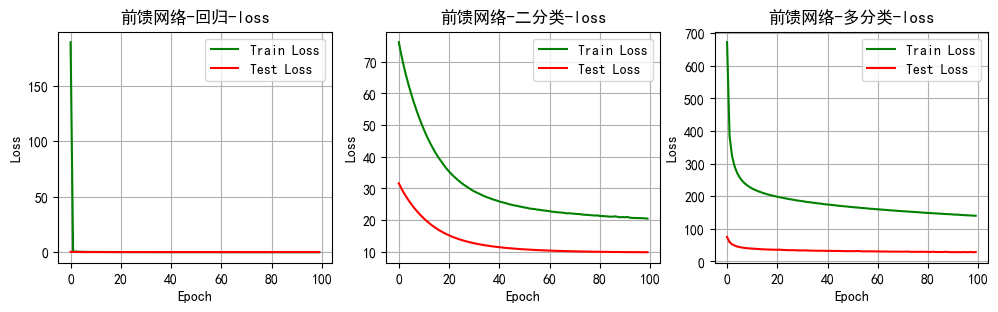

In [18]:
plt.figure(figsize=(12,3))
plt.subplot(131)
picture('前馈网络-回归-loss',train_all_loss21,test_all_loss21)
plt.subplot(132)
picture('前馈网络-二分类-loss',train_all_loss22,test_all_loss22)
plt.subplot(133)
picture('前馈网络-多分类-loss',train_all_loss23,test_all_loss23)
plt.show()


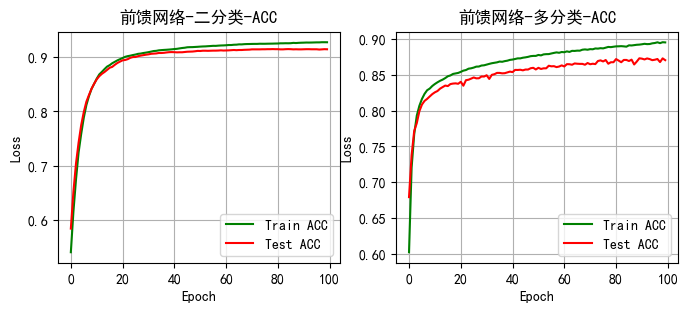

In [19]:
plt.figure(figsize=(8,3))
plt.subplot(121)
picture('前馈网络-二分类-ACC',train_ACC22,test_ACC22,type='ACC')
plt.subplot(122)
picture('前馈网络-多分类-ACC',train_ACC23,test_ACC23,type='ACC')
plt.show()


## 三、在多分类任务中使用至少三种不同的激活函数

In [20]:
def ComPlot(datalist,title='1',ylabel='Loss',flag='act'):
    plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
    plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.plot(datalist[0],label='Tanh' if flag=='act' else '[128]')
    plt.plot(datalist[1],label='Sigmoid' if flag=='act' else '[512 256]')
    plt.plot(datalist[2],label='ELu' if flag=='act' else '[512 256 128 64]')
    plt.plot(datalist[3],label='Relu' if flag=='act' else '[256]')
    plt.legend()
    plt.grid(True)


In [21]:
# 使用实验二中多分类的模型定义其激活函数为 Tanh
model31 = MyNet23(1,28*28,[256],10,act='tanh') 
model31 = model31.to(device) # 若有gpu则放在gpu上训练
# 调用实验二中定义的训练函数，避免重复编写代码
train_all_loss31,test_all_loss31,train_ACC31,test_ACC31 = train_and_test(model=model31)


你本次使用的激活函数为 tanh
MyNet23(
  (input_layer): Flatten(start_dim=1, end_dim=-1)
  (hidden_layers): Linear(in_features=784, out_features=256, bias=True)
  (output_layer): Linear(in_features=256, out_features=10, bias=True)
  (act): Tanh()
)
epoch: 1 | train loss:611.17492 | test loss:71.59687 | train acc:0.635017 test acc:0.69270:
epoch: 4 | train loss:288.43163 | test loss:48.23813 | train acc:0.793500 test acc:0.78710:
epoch: 8 | train loss:238.60831 | test loss:41.48759 | train acc:0.825800 test acc:0.81600:
epoch: 12 | train loss:219.02009 | test loss:38.81362 | train acc:0.837917 test acc:0.82540:
epoch: 16 | train loss:207.73264 | test loss:37.17280 | train acc:0.844917 test acc:0.83290:
epoch: 20 | train loss:199.91082 | test loss:36.10878 | train acc:0.850100 test acc:0.83610:
epoch: 24 | train loss:194.08986 | test loss:35.30729 | train acc:0.854183 test acc:0.84070:
epoch: 28 | train loss:189.41002 | test loss:34.52187 | train acc:0.858100 test acc:0.84160:
epoch: 32 | train loss:

In [22]:
# 使用实验二中多分类的模型定义其激活函数为 Sigmoid
model32 = MyNet23(1,28*28,[256],10,act='sigmoid') 
model32 = model32.to(device) # 若有gpu则放在gpu上训练
# 调用实验二中定义的训练函数，避免重复编写代码
train_all_loss32,test_all_loss32,train_ACC32,test_ACC32 = train_and_test(model=model32)


你本次使用的激活函数为 sigmoid
MyNet23(
  (input_layer): Flatten(start_dim=1, end_dim=-1)
  (hidden_layers): Linear(in_features=784, out_features=256, bias=True)
  (output_layer): Linear(in_features=256, out_features=10, bias=True)
  (act): Sigmoid()
)
epoch: 1 | train loss:995.28176 | test loss:150.66031 | train acc:0.479850 test acc:0.56730:
epoch: 4 | train loss:519.59877 | test loss:82.30832 | train acc:0.705017 test acc:0.70620:
epoch: 8 | train loss:368.39923 | test loss:61.26765 | train acc:0.740217 test acc:0.73700:
epoch: 12 | train loss:319.26911 | test loss:54.00576 | train acc:0.760967 test acc:0.75630:
epoch: 16 | train loss:293.24955 | test loss:49.96621 | train acc:0.777683 test acc:0.77050:
epoch: 20 | train loss:275.39991 | test loss:47.24502 | train acc:0.792300 test acc:0.78630:
epoch: 24 | train loss:261.99563 | test loss:45.28338 | train acc:0.802917 test acc:0.79360:
epoch: 28 | train loss:251.80557 | test loss:43.73847 | train acc:0.812017 test acc:0.80210:
epoch: 32 | trai

In [23]:
# 使用实验二中多分类的模型定义其激活函数为 ELU
model33 = MyNet23(1,28*28,[256],10,act='elu') 
model33 = model33.to(device) # 若有gpu则放在gpu上训练
# 调用实验二中定义的训练函数，避免重复编写代码m
train_all_loss33,test_all_loss33,train_ACC33,test_ACC33 = train_and_test(model=model33)


你本次使用的激活函数为 elu
MyNet23(
  (input_layer): Flatten(start_dim=1, end_dim=-1)
  (hidden_layers): Linear(in_features=784, out_features=256, bias=True)
  (output_layer): Linear(in_features=256, out_features=10, bias=True)
  (act): ELU(alpha=1.0)
)
epoch: 1 | train loss:607.23229 | test loss:70.89929 | train acc:0.629917 test acc:0.68750:
epoch: 4 | train loss:287.88980 | test loss:48.18334 | train acc:0.795033 test acc:0.79000:
epoch: 8 | train loss:240.10416 | test loss:41.76733 | train acc:0.826667 test acc:0.81740:
epoch: 12 | train loss:221.70212 | test loss:39.30139 | train acc:0.838050 test acc:0.82580:
epoch: 16 | train loss:211.42852 | test loss:37.95355 | train acc:0.844783 test acc:0.82840:
epoch: 20 | train loss:204.41577 | test loss:36.76983 | train acc:0.849400 test acc:0.83470:
epoch: 24 | train loss:199.17397 | test loss:36.40948 | train acc:0.852067 test acc:0.83580:
epoch: 28 | train loss:195.03254 | test loss:35.46705 | train acc:0.856150 test acc:0.84030:
epoch: 32 | trai

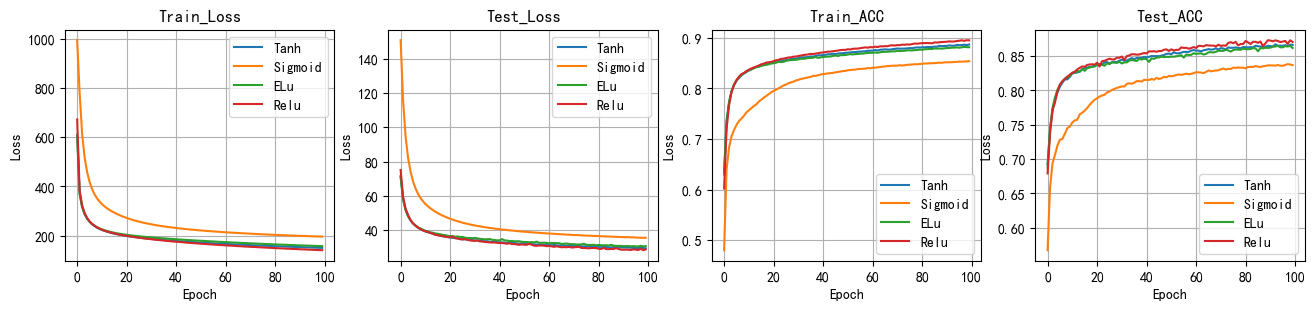

In [24]:
plt.figure(figsize=(16,3))
plt.subplot(141)
ComPlot([train_all_loss31,train_all_loss32,train_all_loss33,train_all_loss23],title='Train_Loss')
plt.subplot(142)
ComPlot([test_all_loss31,test_all_loss32,test_all_loss33,test_all_loss23],title='Test_Loss')
plt.subplot(143)
ComPlot([train_ACC31,train_ACC32,train_ACC33,train_ACC23],title='Train_ACC')
plt.subplot(144)
ComPlot([test_ACC31,test_ACC32,test_ACC33,test_ACC23],title='Test_ACC')
plt.show()


### 4. 对多分类任务中的模型评估隐藏层层数和隐藏单元个数对实验结果的影响

In [25]:
# 使用实验二中多分类的模型  一个隐藏层，神经元个数为[128]
model41 = MyNet23(1,28*28,[128],10,act='relu') 
model41 = model41.to(device) # 若有gpu则放在gpu上训练
# 调用实验二中定义的训练函数，避免重复编写代码
train_all_loss41,test_all_loss41,train_ACC41,test_ACC41 = train_and_test(model=model41)


你本次使用的激活函数为 relu
MyNet23(
  (input_layer): Flatten(start_dim=1, end_dim=-1)
  (hidden_layers): Linear(in_features=784, out_features=128, bias=True)
  (output_layer): Linear(in_features=128, out_features=10, bias=True)
  (act): ReLU()
)
epoch: 1 | train loss:695.00137 | test loss:77.99147 | train acc:0.591883 test acc:0.66060:
epoch: 4 | train loss:300.49961 | test loss:49.78630 | train acc:0.781483 test acc:0.78370:
epoch: 8 | train loss:243.46425 | test loss:42.52341 | train acc:0.824867 test acc:0.81120:
epoch: 12 | train loss:222.04623 | test loss:39.59465 | train acc:0.838150 test acc:0.82730:
epoch: 16 | train loss:210.30151 | test loss:38.50932 | train acc:0.845433 test acc:0.82430:
epoch: 20 | train loss:201.95113 | test loss:36.25784 | train acc:0.851733 test acc:0.83800:
epoch: 24 | train loss:195.48222 | test loss:35.73882 | train acc:0.856433 test acc:0.83820:
epoch: 28 | train loss:190.03715 | test loss:34.55543 | train acc:0.859633 test acc:0.84590:
epoch: 32 | train loss:

In [ ]:
# 使用实验二中多分类的模型 两个隐藏层，神经元个数为[512，256]
model42 = MyNet23(2,28*28,[512,256],10,act='relu') 
model42 = model42.to(device) # 若有gpu则放在gpu上训练
# 调用实验二中定义的训练函数，避免重复编写代码
train_all_loss42,test_all_loss42,train_ACC42,test_ACC42 = train_and_test(model=model42)


你本次使用的激活函数为 relu
MyNet23(
  (input_layer): Flatten(start_dim=1, end_dim=-1)
  (hidden_layers): Sequential(
    (hidden_layer1): Linear(in_features=784, out_features=512, bias=True)
    (hidden_layer2): Linear(in_features=512, out_features=256, bias=True)
  )
  (output_layer): Linear(in_features=256, out_features=10, bias=True)
  (act): ReLU()
)
epoch: 1 | train loss:721.29150 | test loss:78.41532 | train acc:0.545133 test acc:0.65250:
epoch: 4 | train loss:292.77805 | test loss:48.32191 | train acc:0.783317 test acc:0.78400:
epoch: 8 | train loss:234.04757 | test loss:40.85154 | train acc:0.827200 test acc:0.81400:
epoch: 12 | train loss:215.30899 | test loss:38.88076 | train acc:0.839400 test acc:0.82150:
epoch: 16 | train loss:204.21441 | test loss:38.68765 | train acc:0.848850 test acc:0.82400:
epoch: 20 | train loss:196.85483 | test loss:36.88972 | train acc:0.854167 test acc:0.83180:
epoch: 24 | train loss:190.70869 | test loss:34.79236 | train acc:0.858283 test acc:0.84520:
epoch

In [27]:
# 使用实验二中多分类的模型  四个隐藏层，神经元个数为[512，256，128，64]
model43 = MyNet23(3,28*28,[512,256,128],10,act='relu') 
model43 = model43.to(device) # 若有gpu则放在gpu上训练
# 调用实验二中定义的训练函数，避免重复编写代码
train_all_loss43,test_all_loss43,train_ACC43,test_ACC43 = train_and_test(model=model43)


你本次使用的激活函数为 relu
MyNet23(
  (input_layer): Flatten(start_dim=1, end_dim=-1)
  (hidden_layers): Sequential(
    (hidden_layer1): Linear(in_features=784, out_features=512, bias=True)
    (hidden_layer2): Linear(in_features=512, out_features=256, bias=True)
    (hidden_layer3): Linear(in_features=256, out_features=128, bias=True)
  )
  (output_layer): Linear(in_features=128, out_features=10, bias=True)
  (act): ReLU()
)
epoch: 1 | train loss:826.77909 | test loss:89.48904 | train acc:0.445700 test acc:0.63010:
epoch: 4 | train loss:305.85101 | test loss:50.38154 | train acc:0.767517 test acc:0.77170:
epoch: 8 | train loss:239.68796 | test loss:42.97212 | train acc:0.821667 test acc:0.80420:
epoch: 12 | train loss:217.67101 | test loss:38.96346 | train acc:0.838133 test acc:0.82460:
epoch: 16 | train loss:206.04523 | test loss:38.11280 | train acc:0.846367 test acc:0.82940:
epoch: 20 | train loss:197.72918 | test loss:37.02766 | train acc:0.852317 test acc:0.83230:
epoch: 24 | train loss:1

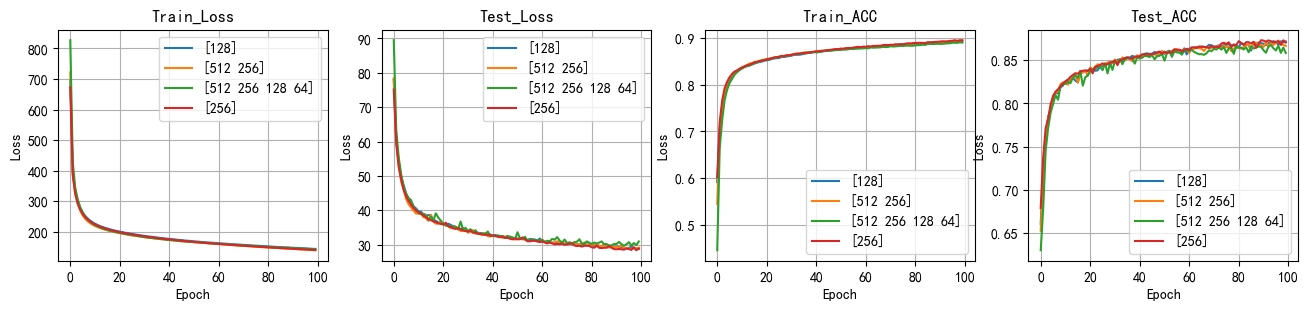

In [28]:
plt.figure(figsize=(16,3))
plt.subplot(141)
ComPlot([train_all_loss41,train_all_loss42,train_all_loss43,train_all_loss23],title='Train_Loss',flag='hidden')
plt.subplot(142)
ComPlot([test_all_loss41,test_all_loss42,test_all_loss43,test_all_loss23],title='Test_Loss',flag='hidden')
plt.subplot(143)
ComPlot([train_ACC41,train_ACC42,train_ACC43,train_ACC23],title='Train_ACC',flag='hidden')
plt.subplot(144)
ComPlot([test_ACC41,test_ACC42,test_ACC43,test_ACC23],title='Test_ACC', flag='hidden')
plt.show()



### 5. 在多分类任务中分别手动实现和用torch.nn实现dropout

In [30]:
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torch.nn.functional import cross_entropy, binary_cross_entropy
from torch.nn import CrossEntropyLoss
from torchvision import transforms
from sklearn import  metrics
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 如果有gpu则在gpu上计算 加快计算速度
print(f'当前使用的device为{device}')
# 数据集定义
# 定义多分类数据集 - train_dataloader - test_dataloader
batch_size = 128
# Build the training and testing dataset
traindataset = torchvision.datasets.FashionMNIST(root='../data',
                                                  train=True,
                                                  download=True,
                                                  transform=transforms.ToTensor())
testdataset = torchvision.datasets.FashionMNIST(root='../data',
                                                 train=False,
                                                 download=True,
                                                 transform=transforms.ToTensor())
traindataloader = torch.utils.data.DataLoader(traindataset, batch_size=batch_size, shuffle=True)
testdataloader = torch.utils.data.DataLoader(testdataset, batch_size=batch_size, shuffle=False)  
# 绘制图像的代码
def picture(name, trainl, testl,xlabel='Epoch',ylabel='Loss'):
    plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
    plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题
    plt.figure(figsize=(8, 3))
    plt.title(name[-1]) # 命名
    color = ['g','r','b','c']
    if trainl is not None:
        plt.subplot(121)
        for i in range(len(name)-1):
            plt.plot(trainl[i], c=color[i],label=name[i])
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)
            plt.legend()
    if testl is not None:
        plt.subplot(122)
        for i in range(len(name)-1):
            plt.plot(testl[i], c=color[i], label=name[i])
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)
            plt.legend()
print(f'多分类数据集 样本总数量{len(traindataset) + len(testdataset)},训练样本数量{len(traindataset)},测试样本数量{len(testdataset)}')


当前使用的device为cuda
多分类数据集 样本总数量70000,训练样本数量60000,测试样本数量10000


In [35]:
# 定义自己的前馈神经网络
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
# dropout = 0.2
class MyNet():
    def __init__(self,dropout=0.0):
        # 设置隐藏层和输出层的节点数
        # global dropout
        self.dropout = dropout
        print('dropout: ',self.dropout)
        self.is_train = None
        num_inputs, num_hiddens, num_outputs = 28 * 28, 256, 10  # 十分类问题
        w_1 = torch.tensor(np.random.normal(0, 0.01, (num_hiddens, num_inputs)), dtype=torch.float32,
                           requires_grad=True)
        b_1 = torch.zeros(num_hiddens, dtype=torch.float32, requires_grad=True)
        w_2 = torch.tensor(np.random.normal(0, 0.01, (num_outputs, num_hiddens)), dtype=torch.float32,
                           requires_grad=True)
        b_2 = torch.zeros(num_outputs, dtype=torch.float32, requires_grad=True)
        self.params = [w_1, b_1, w_2, b_2]
        self.w = [w_1,w_2]
        # 定义模型结构
        self.input_layer = lambda x: x.view(x.shape[0], -1)
        self.hidden_layer = lambda x: self.my_relu(torch.matmul(x, w_1.t()) + b_1)
        self.output_layer = lambda x: torch.matmul(x, w_2.t()) + b_2
    
    def my_relu(self, x):
        return torch.max(input=x, other=torch.tensor(0.0))
    # 以下两个函数分别在训练和测试前调用，选择是否需要dropout
    def train(self):
        self.is_train = True
    def test(self):
        self.is_train = False
    """
    定义dropout层
    x: 输入数据
    dropout: 随机丢弃的概率
    """
    def dropout_layer(self, x):
        dropout =self.dropout
        assert 0 <= dropout <= 1 #dropout值必须在0-1之间
        # dropout==1，所有元素都被丢弃。
        if dropout == 1:
            return torch.zeros_like(x)
            # 在本情况中，所有元素都被保留。
        if dropout == 0:
            return x
        mask = (torch.rand(x.shape) < 1.0 - dropout).float() #rand()返回一个张量，包含了从区间[0, 1)的均匀分布中抽取的一组随机数
        return mask * x / (1.0 - dropout)
        # 定义前向传播
    def forward(self, x):
        x = self.input_layer(x)
        if self.is_train: # 如果是训练过程，则需要开启dropout 否则 需要关闭 dropout
            x = self.dropout_layer(x) 
        x = self.my_relu(self.hidden_layer(x))
        if self.is_train:
            x = self.dropout_layer(x)
        x = self.output_layer(x)
        return x


# 默认的优化函数为手写的mySGD
def mySGD(params, lr, batchsize):
    for param in params:
        param.data -= lr * param.grad

# 定义L2范数惩罚项 参数 w 为模型的 w 在本次实验中为[w_1, w_2] batch_size=128
def l2_penalty(w):
    cost = 0
    for i in range(len(w)):
        cost += (w[i]**2).sum()
    return cost / batch_size / 2
"""
定义训练函数
model:定义的模型 默认为MyNet(0) 即无dropout的初始网络
epochs:训练总轮数 默认为30
criterion:定义的损失函数，默认为cross_entropy
lr :学习率 默认为0.1
optimizer:定义的优化函数，默认为自己定义的mySGD函数
"""
def train_and_test(model=MyNet(),init_states=None,optimizer=mySGD,epochs=20,lr=0.01,L2=False,lambd=0):
    train_all_loss = []  # 记录训练集上得loss变化
    test_all_loss = []  # 记录测试集上的loss变化
    train_ACC, test_ACC = [], [] # 记录正确的个数
    begintime = time.time()
    # 激活函数为自己定义的mySGD函数
    # criterion = cross_entropy # 损失函数为交叉熵函数
    criterion = CrossEntropyLoss() # 损失函数
    model.train() #表明当前处于训练状态，允许使用dropout
    for epoch in range(epochs):
        train_l,train_acc_num = 0, 0
        for data, labels in traindataloader:
            pred = model.forward(data)
            train_each_loss = criterion(pred, labels)  # 计算每次的损失值
            # 若L2为True则表示需要添加L2范数惩罚项
            if L2 == True:
                train_each_loss += lambd * l2_penalty(model.w)
            train_l += train_each_loss.item()
            train_each_loss.backward()  # 反向传播
            # 若当前states为 None表示 使用的是 默认的优化函数mySGD
            if init_states == None: 
                optimizer(model.params, lr, 128)  # 使用小批量随机梯度下降迭代模型参数
            # 否则的话使用的是自己定义的优化器，通过传入的参数，来实现优化效果
            else:
                states = init_states(model.params)
                optimizer(model.params,states,lr=lr)
            # 梯度清零
            train_acc_num += (pred.argmax(dim=1)==labels).sum().item()
            for param in model.params:
                param.grad.data.zero_()
            # print(train_each_loss)
        train_all_loss.append(train_l)  # 添加损失值到列表中
        train_ACC.append(train_acc_num / len(traindataset)) # 添加准确率到列表中
        model.test() # 表明当前处于测试状态，无需使用dropout
        with torch.no_grad():
            is_train = False  # 表明当前为测试阶段，不需要dropout参与
            test_l, test_acc_num = 0, 0
            for data, labels in testdataloader:
                pred = model.forward(data)
                test_each_loss = criterion(pred, labels)
                test_l += test_each_loss.item()
                test_acc_num += (pred.argmax(dim=1)==labels).sum().item()
            test_all_loss.append(test_l)
            test_ACC.append(test_acc_num / len(testdataset))   # # 添加准确率到列表中
        if epoch == 0 or (epoch + 1) % 2 == 0:
            print('epoch: %d | train loss:%.5f | test loss:%.5f | train acc: %.2f | test acc: %.2f'
                  % (epoch + 1, train_l, test_l, train_ACC[-1],test_ACC[-1]))
    endtime = time.time()
    print("手动实现dropout = %d, %d轮 总用时: %.3f" % (model.dropout, epochs, endtime - begintime))
    return train_all_loss,test_all_loss,train_ACC,test_ACC


dropout:  0.0


In [36]:
# 设置dropout = 0  dropout = 0  epoch = 30  lr = 0.01  optimizer = mySGD

model_11 = MyNet(dropout = 0.0)
train_all_loss11,test_all_loss11,\
train_ACC11,test_ACC11 \
= train_and_test(model=model_11,epochs=20,lr=0.01)


dropout:  0.0
epoch: 1 | train loss:862.99221 | test loss:101.06150 | train acc: 0.42 | test acc: 0.62
epoch: 2 | train loss:483.24507 | test loss:70.44706 | train acc: 0.65 | test acc: 0.66
epoch: 4 | train loss:337.97776 | test loss:55.74148 | train acc: 0.74 | test acc: 0.75
epoch: 6 | train loss:288.97523 | test loss:48.79190 | train acc: 0.79 | test acc: 0.78
epoch: 8 | train loss:261.17370 | test loss:44.84584 | train acc: 0.81 | test acc: 0.80
epoch: 10 | train loss:244.38365 | test loss:42.42857 | train acc: 0.82 | test acc: 0.81
epoch: 12 | train loss:233.05408 | test loss:41.40078 | train acc: 0.83 | test acc: 0.81
epoch: 14 | train loss:225.00173 | test loss:39.83145 | train acc: 0.84 | test acc: 0.82
epoch: 16 | train loss:218.84258 | test loss:39.20286 | train acc: 0.84 | test acc: 0.82
epoch: 18 | train loss:213.75431 | test loss:38.26353 | train acc: 0.84 | test acc: 0.83
epoch: 20 | train loss:209.39474 | test loss:37.54921 | train acc: 0.85 | test acc: 0.83
手动实现dropout

In [37]:
# 设置dropout = 0.3  epoch = 30  lr = 0.01  optimizer = mySGD
dropout=0.3
model_12 = MyNet()
train_all_loss12,test_all_loss12,\
train_ACC12,test_ACC12 \
= train_and_test(model=model_12,epochs=20,lr=0.01)


dropout:  0.0
epoch: 1 | train loss:855.79763 | test loss:99.65937 | train acc: 0.43 | test acc: 0.62
epoch: 2 | train loss:479.78502 | test loss:70.24032 | train acc: 0.65 | test acc: 0.67
epoch: 4 | train loss:337.69745 | test loss:55.52135 | train acc: 0.74 | test acc: 0.74
epoch: 6 | train loss:289.60574 | test loss:48.95258 | train acc: 0.79 | test acc: 0.78
epoch: 8 | train loss:261.93675 | test loss:44.82364 | train acc: 0.81 | test acc: 0.80
epoch: 10 | train loss:244.83936 | test loss:42.70479 | train acc: 0.82 | test acc: 0.81
epoch: 12 | train loss:233.46183 | test loss:40.93283 | train acc: 0.83 | test acc: 0.82
epoch: 14 | train loss:225.36539 | test loss:40.00415 | train acc: 0.84 | test acc: 0.82
epoch: 16 | train loss:219.17127 | test loss:38.90534 | train acc: 0.84 | test acc: 0.83
epoch: 18 | train loss:214.08558 | test loss:38.13467 | train acc: 0.84 | test acc: 0.83
epoch: 20 | train loss:210.20765 | test loss:37.89126 | train acc: 0.85 | test acc: 0.83
手动实现dropout 

In [38]:
# 设置dropout = 0.6  dropout = 0.6  epoch = 30  lr = 0.01  optimizer = mySGD

model_13 = MyNet(dropout=0.6)
train_all_loss13,test_all_loss13,\
train_ACC13,test_ACC13 \
= train_and_test(model=model_13,epochs=20,lr=0.01)


dropout:  0.6
epoch: 1 | train loss:909.00242 | test loss:107.81644 | train acc: 0.34 | test acc: 0.62
epoch: 2 | train loss:503.39880 | test loss:71.90791 | train acc: 0.65 | test acc: 0.67
epoch: 4 | train loss:341.41489 | test loss:56.05618 | train acc: 0.74 | test acc: 0.74
epoch: 6 | train loss:291.41992 | test loss:49.05622 | train acc: 0.79 | test acc: 0.78
epoch: 8 | train loss:263.05522 | test loss:45.13766 | train acc: 0.81 | test acc: 0.80
epoch: 10 | train loss:245.84641 | test loss:42.63890 | train acc: 0.82 | test acc: 0.81
epoch: 12 | train loss:234.38294 | test loss:40.99113 | train acc: 0.83 | test acc: 0.82
epoch: 14 | train loss:226.25450 | test loss:39.88859 | train acc: 0.83 | test acc: 0.82
epoch: 16 | train loss:219.89047 | test loss:38.92285 | train acc: 0.84 | test acc: 0.83
epoch: 18 | train loss:214.62641 | test loss:38.17857 | train acc: 0.84 | test acc: 0.83
epoch: 20 | train loss:210.50338 | test loss:37.69425 | train acc: 0.85 | test acc: 0.83
手动实现dropout

In [39]:
# 设置dropout = 0.9  dropout = 0.9  epoch = 20  lr = 0.01  optimizer = mySGD

model_14 = MyNet(dropout=0.9)
train_all_loss14,test_all_loss14,\
train_ACC14,test_ACC14 \
= train_and_test(model=model_14,epochs=20,lr=0.01)


dropout:  0.9
epoch: 1 | train loss:1002.24259 | test loss:132.09919 | train acc: 0.20 | test acc: 0.59
epoch: 2 | train loss:572.42880 | test loss:77.26194 | train acc: 0.61 | test acc: 0.64
epoch: 4 | train loss:353.29258 | test loss:57.66863 | train acc: 0.72 | test acc: 0.74
epoch: 6 | train loss:298.51844 | test loss:50.04726 | train acc: 0.78 | test acc: 0.78
epoch: 8 | train loss:267.21576 | test loss:45.58405 | train acc: 0.81 | test acc: 0.80
epoch: 10 | train loss:248.25844 | test loss:42.97062 | train acc: 0.82 | test acc: 0.81
epoch: 12 | train loss:235.71469 | test loss:41.64364 | train acc: 0.83 | test acc: 0.82
epoch: 14 | train loss:227.05585 | test loss:40.07103 | train acc: 0.83 | test acc: 0.82
epoch: 16 | train loss:220.43777 | test loss:38.95772 | train acc: 0.84 | test acc: 0.83
epoch: 18 | train loss:215.42371 | test loss:38.71385 | train acc: 0.84 | test acc: 0.83
epoch: 20 | train loss:210.99342 | test loss:37.68844 | train acc: 0.84 | test acc: 0.83
手动实现dropou

In [40]:
# 利用torch.nn实现前馈神经网络-多分类任务
from collections import OrderedDict
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
# 定义自己的前馈神经网络
class MyNet_NN(nn.Module):
    def __init__(self,dropout=0.0):
        super(MyNet_NN, self).__init__()
        # 设置隐藏层和输出层的节点数
        self.num_inputs, self.num_hiddens, self.num_outputs = 28 * 28, 256, 10  # 十分类问题
        # 定义模型结构
        self.input_layer = nn.Flatten()
        self.hidden_layer = nn.Linear(28*28,256)
        # 根据设置的dropout设置丢失率
        self.drop = nn.Dropout(dropout)
        self.output_layer = nn.Linear(256,10)
        # 使用relu激活函数
        self.relu = nn.ReLU()
        
    # 定义前向传播
    def forward(self, x):
        x = self.drop(self.input_layer(x))
        x = self.drop(self.hidden_layer(x))
        x = self.relu(x)
        x = self.output_layer(x)
        return x

# 训练
# 使用默认的参数即： num_inputs=28*28,num_hiddens=256,num_outs=10,act='relu'
model = MyNet_NN()  
model = model.to(device)

# 将训练过程定义为一个函数，方便调用
def train_and_test_NN(model=model,epochs=30,lr=0.01,weight_decay=0.0,optimizer=None):
    MyModel = model
    print(MyModel)
     # 优化函数, 默认情况下weight_decay为0 通过更改weight_decay的值可以实现L2正则化。
    # 默认的优化函数为SGD 可以根据参数来修改优化函数
    if optimizer == None:
        optimizer = SGD(MyModel.parameters(), lr=lr,weight_decay=weight_decay) 
    criterion = CrossEntropyLoss() # 损失函数
    criterion = criterion.to(device)
    train_all_loss = []  # 记录训练集上得loss变化
    test_all_loss = []  # 记录测试集上的loss变化
    train_ACC, test_ACC = [], []
    begintime = time.time()
    for epoch in range(epochs):
        train_l, train_epoch_count, test_epoch_count = 0, 0, 0
        for data, labels in traindataloader:
            data, labels = data.to(device), labels.to(device)
            pred = MyModel(data)
            train_each_loss = criterion(pred, labels.view(-1))  # 计算每次的损失值
            optimizer.zero_grad()  # 梯度清零
            train_each_loss.backward()  # 反向传播
            optimizer.step()  # 梯度更新
            train_l += train_each_loss.item()
            train_epoch_count += (pred.argmax(dim=1)==labels).sum()
        train_ACC.append(train_epoch_count/len(traindataset))
        train_all_loss.append(train_l)  # 添加损失值到列表中
        with torch.no_grad():
            test_loss, test_epoch_count= 0, 0
            for data, labels in testdataloader:
                data, labels = data.to(device), labels.to(device)
                pred = MyModel(data)
                test_each_loss = criterion(pred,labels)
                test_loss += test_each_loss.item()
                test_epoch_count += (pred.argmax(dim=1)==labels).sum()
            test_all_loss.append(test_loss)
            test_ACC.append(test_epoch_count.cpu()/len(testdataset))
        if epoch == 0 or (epoch + 1) % 2 == 0:
            print('epoch: %d | train loss:%.5f | test loss:%.5f | train acc:%5f test acc:%.5f:' % (epoch + 1, train_all_loss[-1], test_all_loss[-1],
                                                                                                                     train_ACC[-1],test_ACC[-1]))
    endtime = time.time()
    print("torch.nn实现前馈网络-多分类任务 %d轮 总用时: %.3fs" % (epochs, endtime - begintime))
    # 返回训练集和测试集上的 损失值 与 准确率
    return train_all_loss,test_all_loss,train_ACC,test_ACC


In [41]:
# 设置dropout = 0  dropout = 0  epoch = 20  lr = 0.01  optimizer = SGD

model_15 = MyNet_NN(dropout=0)
model_15 = model_15.to(device)
train_all_loss15,test_all_loss15,\
train_ACC15,test_ACC15 \
= train_and_test_NN(model=model_15,epochs=20,lr=0.01)


MyNet_NN(
  (input_layer): Flatten(start_dim=1, end_dim=-1)
  (hidden_layer): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0, inplace=False)
  (output_layer): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
)
epoch: 1 | train loss:672.20470 | test loss:75.46394 | train acc:0.593633 test acc:0.67530:
epoch: 2 | train loss:386.71404 | test loss:59.76812 | train acc:0.718233 test acc:0.73200:
epoch: 4 | train loss:295.50501 | test loss:49.35997 | train acc:0.787583 test acc:0.78190:
epoch: 6 | train loss:260.94446 | test loss:44.55222 | train acc:0.812000 test acc:0.80550:
epoch: 8 | train loss:242.03127 | test loss:42.23059 | train acc:0.824217 test acc:0.81340:
epoch: 10 | train loss:230.11838 | test loss:40.46292 | train acc:0.832317 test acc:0.82020:
epoch: 12 | train loss:221.87763 | test loss:39.50497 | train acc:0.837400 test acc:0.82480:
epoch: 14 | train loss:215.48112 | test loss:38.22423 | train acc:0.841567 test acc:0.82920:
epo

In [42]:
# 设置dropout = 0  dropout = 0  epoch = 20  lr = 0.01  optimizer = SGD
model_16 = MyNet_NN(dropout=0.3)
model_16 = model_16.to(device)
train_all_loss16,test_all_loss16,\
train_ACC16,test_ACC16 \
= train_and_test_NN(model=model_16,epochs=20,lr=0.01)


MyNet_NN(
  (input_layer): Flatten(start_dim=1, end_dim=-1)
  (hidden_layer): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.3, inplace=False)
  (output_layer): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
)
epoch: 1 | train loss:691.68003 | test loss:80.74128 | train acc:0.548217 test acc:0.64380:
epoch: 2 | train loss:416.58473 | test loss:65.61836 | train acc:0.690250 test acc:0.70870:
epoch: 4 | train loss:330.47310 | test loss:55.24886 | train acc:0.757800 test acc:0.75170:
epoch: 6 | train loss:298.05604 | test loss:50.68834 | train acc:0.781267 test acc:0.77350:
epoch: 8 | train loss:280.67004 | test loss:48.11656 | train acc:0.793150 test acc:0.78810:
epoch: 10 | train loss:268.55335 | test loss:46.66861 | train acc:0.801917 test acc:0.79010:
epoch: 12 | train loss:259.94789 | test loss:45.21459 | train acc:0.808550 test acc:0.79740:
epoch: 14 | train loss:252.27529 | test loss:44.09749 | train acc:0.812283 test acc:0.80320:
e

In [43]:
# 设置dropout = 0  dropout = 0  epoch = 20  lr = 0.01  optimizer = SGD
model_17 = MyNet_NN(dropout=0.6)
model_17 = model_17.to(device)
train_all_loss17,test_all_loss17,\
train_ACC17,test_ACC17 \
= train_and_test_NN(model=model_17,epochs=20,lr=0.01)


MyNet_NN(
  (input_layer): Flatten(start_dim=1, end_dim=-1)
  (hidden_layer): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.6, inplace=False)
  (output_layer): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
)
epoch: 1 | train loss:764.01685 | test loss:94.59139 | train acc:0.438867 test acc:0.57500:
epoch: 2 | train loss:495.14472 | test loss:76.85899 | train acc:0.619833 test acc:0.64090:
epoch: 4 | train loss:398.51214 | test loss:66.35327 | train acc:0.694500 test acc:0.69770:
epoch: 6 | train loss:363.90453 | test loss:62.15635 | train acc:0.720617 test acc:0.71780:
epoch: 8 | train loss:344.26780 | test loss:58.57738 | train acc:0.737150 test acc:0.73510:
epoch: 10 | train loss:330.58406 | test loss:56.44925 | train acc:0.747483 test acc:0.74280:
epoch: 12 | train loss:320.28103 | test loss:54.81413 | train acc:0.754983 test acc:0.74850:
epoch: 14 | train loss:311.27089 | test loss:53.47221 | train acc:0.759950 test acc:0.75230:
e

In [44]:
# 设置dropout = 0  dropout = 0  epoch = 20  lr = 0.01  optimizer = SGD
model_18 = MyNet_NN(dropout=0.9)
model_18 = model_18.to(device)
train_all_loss18,test_all_loss18,\
train_ACC18,test_ACC18 \
= train_and_test_NN(model=model_18,epochs=20,lr=0.01)


MyNet_NN(
  (input_layer): Flatten(start_dim=1, end_dim=-1)
  (hidden_layer): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.9, inplace=False)
  (output_layer): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
)
epoch: 1 | train loss:1030.91290 | test loss:152.28315 | train acc:0.192017 test acc:0.27570:
epoch: 2 | train loss:835.89519 | test loss:132.05569 | train acc:0.318633 test acc:0.35740:
epoch: 4 | train loss:702.33477 | test loss:116.07909 | train acc:0.412967 test acc:0.42210:
epoch: 6 | train loss:652.86620 | test loss:109.22833 | train acc:0.456900 test acc:0.46320:
epoch: 8 | train loss:618.90406 | test loss:103.69491 | train acc:0.487100 test acc:0.48700:
epoch: 10 | train loss:595.53792 | test loss:100.80343 | train acc:0.503467 test acc:0.50720:
epoch: 12 | train loss:577.18795 | test loss:97.98017 | train acc:0.518850 test acc:0.52670:
epoch: 14 | train loss:563.54251 | test loss:94.75628 | train acc:0.533917 test acc:0.5

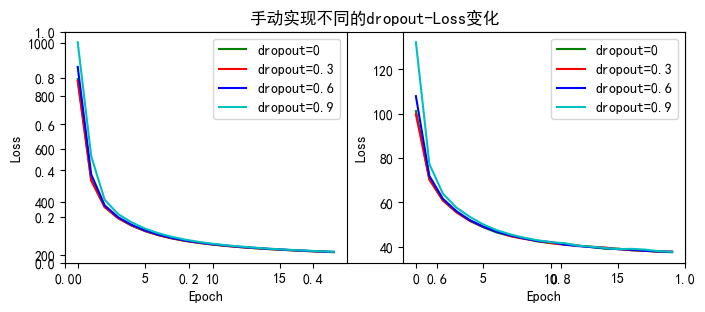

In [46]:
#完成loss的显示
drop_name_1 = ['dropout=0','dropout=0.3','dropout=0.6','dropout=0.9','手动实现不同的dropout-Loss变化']
drop_train_1 = [train_all_loss11,train_all_loss12,train_all_loss13,train_all_loss14]
drop_test_1 = [test_all_loss11,test_all_loss12,test_all_loss13,test_all_loss14]
picture(drop_name_1, drop_train_1,drop_test_1)


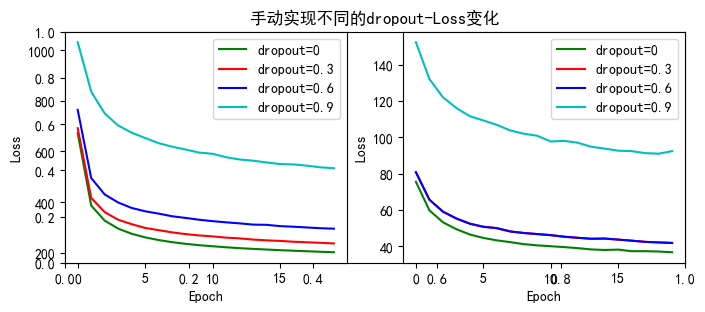

In [47]:
#完成loss的显示
drop_name_2 = ['dropout=0','dropout=0.3','dropout=0.6','dropout=0.9','手动实现不同的dropout-Loss变化']
drop_train_2 = [train_all_loss15,train_all_loss16,train_all_loss17,train_all_loss18]
drop_test_2 = [test_all_loss15,test_all_loss16,test_all_loss16,test_all_loss18]
picture(drop_name_2, drop_train_2, drop_test_2)


### 6. 在多分类任务中分别手动实现和用torch.nn实现L2正则化

In [ ]:
# 定义L2范数惩罚项
def l2_penalty(w):
    cost = 0
    for i in range(len(w)):
        cost += (w[i]**2).sum()
    return cost / batch_size / 2

In [48]:
# 设置dropout = 0  dropout = 0  epoch = 20  lr = 0.01  optimizer = SGD L2=True lambd=0

model_21 = MyNet(dropout=0)
train_all_loss21,test_all_loss21,\
train_ACC21,test_ACC21\
= train_and_test(model=model_21,epochs=20,lr=0.01,L2=True,lambd=0)


dropout:  0
epoch: 1 | train loss:862.00601 | test loss:99.96267 | train acc: 0.48 | test acc: 0.61
epoch: 2 | train loss:480.22800 | test loss:70.22110 | train acc: 0.66 | test acc: 0.67
epoch: 4 | train loss:337.09777 | test loss:55.44052 | train acc: 0.74 | test acc: 0.75
epoch: 6 | train loss:288.70350 | test loss:48.67136 | train acc: 0.79 | test acc: 0.78
epoch: 8 | train loss:261.67072 | test loss:44.82503 | train acc: 0.81 | test acc: 0.80
epoch: 10 | train loss:244.83734 | test loss:42.50657 | train acc: 0.82 | test acc: 0.81
epoch: 12 | train loss:233.75314 | test loss:40.95479 | train acc: 0.83 | test acc: 0.82
epoch: 14 | train loss:225.58521 | test loss:39.76331 | train acc: 0.83 | test acc: 0.82
epoch: 16 | train loss:219.17700 | test loss:39.21785 | train acc: 0.84 | test acc: 0.82
epoch: 18 | train loss:214.10240 | test loss:38.15372 | train acc: 0.84 | test acc: 0.83
epoch: 20 | train loss:209.92370 | test loss:37.45792 | train acc: 0.85 | test acc: 0.83
手动实现dropout = 

In [49]:
# 设置dropout = 0  dropout = 0  epoch = 20  lr = 0.01  optimizer = SGD L2=True lambd=1

model_22 = MyNet(dropout=0)
train_all_loss22,test_all_loss22,\
train_ACC22,test_ACC22\
= train_and_test(model=model_22,epochs=20,lr=0.01,L2=True,lambd=1)


dropout:  0
epoch: 1 | train loss:904.87496 | test loss:101.86769 | train acc: 0.42 | test acc: 0.61
epoch: 2 | train loss:539.79249 | test loss:71.91223 | train acc: 0.65 | test acc: 0.66
epoch: 4 | train loss:407.49624 | test loss:57.27091 | train acc: 0.73 | test acc: 0.74
epoch: 6 | train loss:365.48974 | test loss:50.75796 | train acc: 0.78 | test acc: 0.78
epoch: 8 | train loss:341.27612 | test loss:47.21070 | train acc: 0.80 | test acc: 0.80
epoch: 10 | train loss:326.96366 | test loss:44.78511 | train acc: 0.82 | test acc: 0.81
epoch: 12 | train loss:317.27801 | test loss:43.35862 | train acc: 0.82 | test acc: 0.81
epoch: 14 | train loss:310.49955 | test loss:42.33536 | train acc: 0.83 | test acc: 0.82
epoch: 16 | train loss:305.50718 | test loss:41.62230 | train acc: 0.83 | test acc: 0.82
epoch: 18 | train loss:301.56390 | test loss:40.76669 | train acc: 0.83 | test acc: 0.82
epoch: 20 | train loss:298.51958 | test loss:40.40917 | train acc: 0.84 | test acc: 0.82
手动实现dropout =

In [50]:
# 设置dropout = 0  dropout = 0  epoch = 30  lr = 0.01  optimizer = SGD weight_decay=0.0

model_24 = MyNet_NN(dropout=0)
model_24 = model_24.to(device)
train_all_loss24,test_all_loss24,\
train_ACC24,test_ACC24 \
= train_and_test_NN(model=model_24,epochs=20,lr=0.01,weight_decay=0.0)


MyNet_NN(
  (input_layer): Flatten(start_dim=1, end_dim=-1)
  (hidden_layer): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0, inplace=False)
  (output_layer): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
)
epoch: 1 | train loss:663.69101 | test loss:74.81851 | train acc:0.611967 test acc:0.66870:
epoch: 2 | train loss:384.61507 | test loss:59.66862 | train acc:0.719617 test acc:0.73780:
epoch: 4 | train loss:293.87598 | test loss:49.05102 | train acc:0.790900 test acc:0.78470:
epoch: 6 | train loss:259.59930 | test loss:44.29727 | train acc:0.814050 test acc:0.80730:
epoch: 8 | train loss:241.44755 | test loss:41.78960 | train acc:0.825900 test acc:0.81680:
epoch: 10 | train loss:229.76834 | test loss:40.04919 | train acc:0.832850 test acc:0.82310:
epoch: 12 | train loss:221.32921 | test loss:39.16049 | train acc:0.838117 test acc:0.82410:
epoch: 14 | train loss:215.01437 | test loss:38.06905 | train acc:0.841567 test acc:0.82920:
epo

In [51]:
# 设置dropout = 0  dropout = 0  epoch = 20  lr = 0.01  optimizer = SGD weight_decay=1e-3

model_26 = MyNet_NN(dropout=0)
model_26 = model_26.to(device)
train_all_loss26,test_all_loss26,\
train_ACC26,test_ACC26 \
= train_and_test_NN(model=model_26,epochs=20,lr=0.01,weight_decay=1e-3)


MyNet_NN(
  (input_layer): Flatten(start_dim=1, end_dim=-1)
  (hidden_layer): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0, inplace=False)
  (output_layer): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
)
epoch: 1 | train loss:667.02471 | test loss:75.56209 | train acc:0.618617 test acc:0.67360:
epoch: 2 | train loss:387.32252 | test loss:59.85899 | train acc:0.719367 test acc:0.73790:
epoch: 4 | train loss:294.56921 | test loss:49.02912 | train acc:0.790683 test acc:0.78770:
epoch: 6 | train loss:260.03519 | test loss:44.64852 | train acc:0.815117 test acc:0.80430:
epoch: 8 | train loss:241.94310 | test loss:41.90152 | train acc:0.826150 test acc:0.81670:
epoch: 10 | train loss:230.30144 | test loss:40.47334 | train acc:0.833567 test acc:0.82160:
epoch: 12 | train loss:222.29843 | test loss:39.05806 | train acc:0.837667 test acc:0.82700:
epoch: 14 | train loss:216.01843 | test loss:38.22184 | train acc:0.842483 test acc:0.83060:
epo

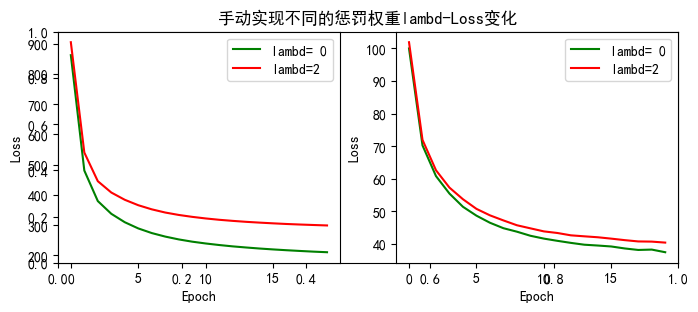

In [52]:
#完成loss的显示
drop_name_3 = ['lambd= 0','lambd=2','手动实现不同的惩罚权重lambd-Loss变化']
drop_train_3 = [train_all_loss21,train_all_loss22]
drop_test_3= [test_all_loss21,test_all_loss22]
picture(drop_name_3, drop_train_3,drop_test_3)


### 7. 对回归、二分类、多分类任务分别选择上述实验中效果最好的模型，采用10折交叉验证评估实验结果

In [65]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random
from pandas import *
%matplotlib inline

In [66]:
#加载数据集
features = torch.rand(10000, 500)
labels = (0.0056 * features).sum(dim=1) + 0.028
labels += torch.tensor(np.random.normal(0,0.01,size=labels.size()), dtype=torch.float)

In [67]:
def get_data_iter(X_train, y_train, X_valid, y_valid,batch_size):
    train_dataset = torch.utils.data.TensorDataset(X_train.cuda(),y_train.cuda())
    test_dataset = torch.utils.data.TensorDataset(X_valid.cuda(),y_valid.cuda())
    train_iter = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
    test_iter = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,shuffle=False)
    return train_iter, test_iter

In [68]:
def get_kfold_data(k, i, X, y):
    fold_size = X.shape[0]//k
    val_start = i * fold_size
    if i  != k - 1:
        val_end = (i + 1) * fold_size
        X_valid, y_valid = X[val_start:val_end],y[val_start:val_end]
        X_train = torch.cat((X[0:val_start],X[val_end:]),dim=0)
        y_train = torch.cat((y[0:val_start],y[val_end:]),dim=0)
    else:
        X_valid,y_valid = X[val_start:], y[val_start:]
        X_train = X[0:val_start]
        y_train = y[0:val_start]
    
    return X_train, y_train, X_valid, y_valid

In [82]:
## 使用model21, model22, model23

## 回归问题
# 训练

from cProfile import label
from cycler import V
from sklearn.model_selection import KFold

res = 0.0

for i in range(10):
    # 数据集定义 生成用于回归任务的数据集
    # 构建回归数据集合 - traindataloader1, testdataloader1
    data_num, train_num, test_num = 10000, 7000, 3000 # 分别为样本总数量，训练集样本数量和测试集样本数量
    true_w, true_b = 0.0056 * torch.ones(500,1), 0.028 
    features = torch.randn(10000, 500)
    labels = torch.matmul(features,true_w) + true_b # 按高斯分布
    labels += torch.tensor(np.random.normal(0,0.01,size=labels.size()),dtype=torch.float32)

    item = (int)(train_num / 10) ## 得到验证集的数量

    # 划分训练集和测试集
    train_features = torch.cat([features[:i * item], features[(i + 1) * item:]], dim=0)
    test_features = features[i * item:(i + 1) * item]
    train_labels = torch.cat([labels[:i * item], labels[(i + 1) * item:]], dim=0)
    test_labels = labels[i * item:(i + 1) * item]
    
    batch_size = 128
    traindataset1 = torch.utils.data.TensorDataset(train_features,train_labels)
    testdataset1 = torch.utils.data.TensorDataset(test_features, test_labels)
    traindataloader1 = torch.utils.data.DataLoader(dataset=traindataset1,batch_size=batch_size,shuffle=True)
    testdataloader1 = torch.utils.data.DataLoader(dataset=testdataset1,batch_size=batch_size,shuffle=True)

    model21 = MyNet21()  # logistics模型
    model21 = model21.to(device)
    criterion = MSELoss()  # 损失函数
    criterion = criterion.to(device)
    optimizer = SGD(model21.parameters(), lr=0.1)  # 优化函数
    epochs = 40  # 训练轮数
    sum = 0.0
    for epoch in range(epochs):
        train_l = 0
        for data, labels in traindataloader1:
            data, labels = data.to(device=device), labels.to(device)
            pred = model21(data)
            train_each_loss = criterion(pred.view(-1, 1), labels.view(-1, 1))  # 计算每次的损失值
            optimizer.zero_grad()  # 梯度清零
            train_each_loss.backward()  # 反向传播
            optimizer.step()  # 梯度更新
        with torch.no_grad():
            test_loss = 0
            for data, labels in testdataloader1:
                data, labels = data.to(device), labels.to(device)
                pred = model21(data)
                test_each_loss = criterion(pred,labels)
                test_loss += test_each_loss.item()
    for data, labels in testdataloader1:
        data, labels = data.to(device), labels.to(device)
        pred = model21(data)
        test_each_loss = criterion(pred, labels)
        sum += test_each_loss.item()
    print('第', i+1, '折验证结果:', sum)
    res += sum
print("最终平均10折交叉验证结果:", res / 10)
    

第 1 折验证结果: 0.03135393373668194
第 2 折验证结果: 0.02460582321509719
第 3 折验证结果: 0.03851716360077262
第 4 折验证结果: 0.02775052422657609
第 5 折验证结果: 0.03959299856796861
第 6 折验证结果: 0.027892481302842498
第 7 折验证结果: 0.03250640071928501
第 8 折验证结果: 0.03418197901919484
第 9 折验证结果: 0.03912712587043643
第 10 折验证结果: 0.029798602918162942
最终平均10折交叉验证结果: 0.03253270331770182


In [91]:

## 生成用于二分类任务的数据集
data_num, train_num, test_num = 10000, 7000, 3000  # 分别为样本总数量，训练集样本数量和测试集样本数量
# 第一个数据集 符合均值为 0.5 标准差为1 得分布
features1 = torch.normal(mean=0.2, std=2, size=(data_num, 200), dtype=torch.float32)
labels1 = torch.ones(data_num)
# 第二个数据集 符合均值为 -0.5 标准差为1的分布
features2 = torch.normal(mean=-0.2, std=2, size=(data_num, 200), dtype=torch.float32)
labels2 = torch.zeros(data_num)

res = 0.0

for i in range(10):

    item = (int)(train_num / 10) ## 得到验证集的数量

    # 构建训练数据集
    train_features2 = torch.cat((features1[:i * item], features1[(i + 1) * item:], features2[:i * item], features2[(i + 1) * item:]), dim=0)  # size torch.Size([14000, 200])
    train_labels2 = torch.cat((labels1[:i * item], labels1[(i + 1) * item:], labels2[:i * item], labels2[(i + 1) * item:]), dim=0)  # size  torch.Size([6000, 200])
    # 构建测试数据集
    test_features2 = torch.cat((features1[i * item:(i + 1) * item], features2[i * item:(i + 1) * item]), dim=0)  # torch.Size([14000])
    test_labels2 = torch.cat((labels1[i * item:(i + 1) * item], labels2[i * item:(i + 1) * item]), dim=0)  # torch.Size([6000])
    batch_size = 128
    # Build the training and testing dataset

    traindataset2 = torch.utils.data.TensorDataset(train_features2, train_labels2)
    testdataset2 = torch.utils.data.TensorDataset(test_features2, test_labels2)
    traindataloader2 = torch.utils.data.DataLoader(dataset=traindataset2,batch_size=batch_size,shuffle=True)
    testdataloader2 = torch.utils.data.DataLoader(dataset=testdataset2,batch_size=batch_size,shuffle=True)

    # 训练
    model22 = MyNet22()  # logistics模型
    model22 = model22.to(device)
    optimizer = SGD(model22.parameters(), lr=0.001)  # 优化函数
    epochs = 40  # 训练轮数
    train_all_loss22 = []  # 记录训练集上得loss变化
    test_all_loss22 = []  # 记录测试集上的loss变化
    train_ACC22, test_ACC22 = [], []
    begintime22 = time.time()
    test_epoch_count = 0
    for epoch in range(epochs):
        for data, labels in traindataloader2:
            data, labels = data.to(device), labels.to(device)
            pred = model22(data)
            train_each_loss = binary_cross_entropy(pred.view(-1), labels.view(-1))  # 计算每次的损失值
            optimizer.zero_grad()  # 梯度清零
            train_each_loss.backward()  # 反向传播
            optimizer.step()  # 梯度更新
            pred = torch.tensor(np.where(pred.cpu()>0.5, 1, 0))  # 大于 0.5时候，预测标签为 1 否则为0
            each_count = (pred.view(-1) == labels.cpu()).sum() # 每一个batchsize的正确个数
    with torch.no_grad():
        test_loss, each_count = 0, 0
        for data, labels in testdataloader2:
            data, labels = data.to(device), labels.to(device)
            pred = model22(data)
            test_each_loss = binary_cross_entropy(pred.view(-1),labels)
            test_loss += test_each_loss.item()
            # .cpu 为转换到cpu上计算
            pred = torch.tensor(np.where(pred.cpu() > 0.5, 1, 0))
            each_count = (pred.view(-1)==labels.cpu().view(-1)).sum()
            test_epoch_count += each_count
            test_ACC22.append(test_epoch_count / len(testdataset2))
    print('第', i+1, '折验证结果:', test_ACC22[-1].item())
    res += test_ACC22[-1].item()
print("最终平均10折交叉验证结果:", res / 10)

第 1 折验证结果: 0.9257143139839172
第 2 折验证结果: 0.9235714077949524
第 3 折验证结果: 0.9214285612106323
第 4 折验证结果: 0.9150000214576721
第 5 折验证结果: 0.9114285707473755
第 6 折验证结果: 0.9214285612106323
第 7 折验证结果: 0.8985714316368103
第 8 折验证结果: 0.9242857098579407
第 9 折验证结果: 0.9092857241630554
第 10 折验证结果: 0.9192857146263123
最终平均10折交叉验证结果: 0.91700000166893


In [111]:
from torch.utils.data import random_split
from sklearn.model_selection import KFold
from torch.utils.data import Subset, ConcatDataset

# 定义多分类数据集 - train_dataloader - test_dataloader
batch_size = 128
# Build the training and testing dataset
fulldataset3 = torchvision.datasets.MNIST(root='../data',
                                                  download=True,
                                                  transform=transforms.ToTensor())

res = 0.0

# 设置5折交叉验证
kf = KFold(n_splits=10, shuffle=True, random_state=42)
for fold, (train_idx, val_idx) in enumerate(kf.split(range(len(fulldataset3)))):
    train_subset = Subset(fulldataset3, train_idx)
    val_subset = Subset(fulldataset3, val_idx)
    
    train_loader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_subset, batch_size=64, shuffle=False)

    # 训练
    model23 = MyNet23()  
    model23 = model23.to(device)

    optimizer = SGD(model23.parameters(), lr=0.01)  # 优化函数
    epochs = 40  # 训练轮数
    criterion = CrossEntropyLoss() # 损失函数
    test_ACC231 = []
    for epoch in range(epochs):
        train_l, train_epoch_count, test_epoch_count = 0, 0, 0
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            pred = model23(data)
            train_each_loss = criterion(pred, labels.view(-1))  # 计算每次的损失值
            optimizer.zero_grad()  # 梯度清零
            train_each_loss.backward()  # 反向传播
            optimizer.step()  # 梯度更新
            train_epoch_count += (pred.argmax(dim=1)==labels).sum()
    test_loss, test_epoch_count= 0, 0
    model23.eval()
    with torch.no_grad():
        val_correct, val_total = 0, 0
        for data, labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model23(data)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
        val_acc = val_correct / val_total
        test_ACC231.append(val_acc)
    print('第', i+1, '折验证结果:', test_ACC231[-1])
    res += test_ACC231[-1]
print("最终平均10折交叉验证结果:", res / 10)

你本次使用的激活函数为 relu
第 10 折验证结果: 0.964
你本次使用的激活函数为 relu
第 10 折验证结果: 0.9601666666666666
你本次使用的激活函数为 relu
第 10 折验证结果: 0.9601666666666666
你本次使用的激活函数为 relu
第 10 折验证结果: 0.963
你本次使用的激活函数为 relu
第 10 折验证结果: 0.9555
你本次使用的激活函数为 relu
第 10 折验证结果: 0.9626666666666667
你本次使用的激活函数为 relu
第 10 折验证结果: 0.9563333333333334
你本次使用的激活函数为 relu
第 10 折验证结果: 0.9601666666666666
你本次使用的激活函数为 relu
第 10 折验证结果: 0.9535
你本次使用的激活函数为 relu
第 10 折验证结果: 0.9608333333333333
最终平均10折交叉验证结果: 0.9596333333333333
